In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference_forecast.git

  Cloning https://github.com/Priesemann-Group/covid19_inference_forecast.git to /private/var/folders/qr/hdfcfrpx0hj50l5g7lwg7ygc0000gn/T/pip-req-build-qdvqthfr
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference_forecast.git /private/var/folders/qr/hdfcfrpx0hj50l5g7lwg7ygc0000gn/T/pip-req-build-qdvqthfr
  on a case-insensitive filesystem) and only one from the same
  colliding group is in the working tree:

    'DISCLAIMER.md'
    'disclaimer.md'
  Created wheel for covid19-inference: filename=covid19_inference-0.0.10-py3-none-any.whl size=27625 sha256=ad89fe9e90ec412304c44d6c779ed71b83e63f6ae9340a4bcf67feab8ec9d2ae
  Stored in directory: /private/var/folders/qr/hdfcfrpx0hj50l5g7lwg7ygc0000gn/T/pip-ephem-wheel-cache-6w6l8fm7/wheels/cc/33/51/375e62e25122e2286fa440949767c3f7f3e2e75f7a2cd4ca7e
Successfully built covid19-inference
You should consider upgrading via the '/Users/jessica/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
pip install pymc3

You should consider upgrading via the '/Users/jessica/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
def filter_one_state(data_df, state, begin_date, end_date):
    """
    Returns the number of cases of one country as a np.array, given a dataframe returned by `get_jhu_confirmed_cases`
    Parameters
    ----------
    data_df : pandas.dataframe
    country : string
    begin_date : datetime.datetime
    end_date: datetime.datetime
    Returns
    -------
    : array
    """
    date_formatted_begin = _format_date(begin_date)
    date_formatted_end = _format_date(end_date)

    y = data_df[(data_df['state']==state)]

    if len(y)==1:
        cases_obs = y.loc[:,date_formatted_begin:date_formatted_end]
    elif len(y)==0:
        cases_obs = data_df[data_df['state']==state].sum().loc[date_formatted_begin:date_formatted_end]

    else:
        raise RuntimeError('Country not found: {}'.format(country))

    return np.array(cases_obs).flatten()

_format_date = lambda date_py: "{}/{}/{}".format(
    date_py.month, date_py.day, str(date_py.year)[2:4]
)


In [4]:
import sys
sys.path.append('../..')
import datetime
import pickle

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pandas as pd

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19


INFO: This code is not longer developed, use our new module instead: github.com/Priesemann-Group/covid19_inference


In [5]:
confirmed_cases_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
confirmed_cases.loc[confirmed_cases['state'] == 'Oklahoma']
confirmed_cases=confirmed_cases[["date","state","cases"]]

In [6]:
confirmed_cases=confirmed_cases.loc[confirmed_cases['state'] == 'Oklahoma']
confirmed_cases=confirmed_cases[["date","cases"]]
confirmed_cases['date'] = pd.to_datetime(confirmed_cases['date'])
date_data_begin = datetime.datetime(2020,8,3)
date_data_end   = datetime.datetime(2020,12,6)
mask = (confirmed_cases['date'] > date_data_begin) & (confirmed_cases['date'] <= date_data_end)
confirmed_cases=confirmed_cases.loc[mask]
cases_obs=confirmed_cases['cases']
cases_obs=np.asarray(cases_obs)
cases_obs


array([ 39452,  40555,  41395,  42234,  43070,  43561,  43962,  44725,
        45392,  46101,  46893,  47798,  48342,  48711,  49326,  49923,
        50669,  51746,  52599,  53165,  53522,  54172,  54838,  55550,
        56260,  57353,  58020,  58733,  59399,  60118,  61027,  62040,
        63187,  63607,  64220,  65053,  65929,  66700,  67642,  68659,
        69354,  70223,  71314,  72284,  73318,  74567,  75804,  76807,
        77908,  79072,  80161,  81244,  82520,  83510,  84333,  85194,
        86219,  87199,  88369,  89559,  90748,  91317,  91982,  93346,
        94352,  95564,  97088,  98621,  99387, 100184, 101493, 102615,
       103836, 105308, 106503, 107299, 108073, 109548, 110855, 112483,
       113856, 115685, 116736, 117399, 118409, 119152, 120193, 121495,
       122762, 124111, 125195, 126526, 127772, 129873, 131751, 136258,
       136258, 138455, 140157, 142334, 144691, 147358, 150205, 154128,
       156857, 158408, 161425, 164340, 167261, 170924, 174330, 177874,
      

In [7]:
    
#confirmed_cases = cov19.get_jhu_confirmed_cases() this repo did not has the state information

date_data_begin = datetime.datetime(2020,8,3)
date_data_end   = datetime.datetime(2020,12,6)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 60
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days




prior_date_mild_dist_begin =  datetime.datetime(2020,8,17)
prior_date_strong_dist_begin =  datetime.datetime(2020,9,7)
prior_date_contact_ban_begin =  datetime.datetime(2020,10,5)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_median_lambda = 0.6,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.5,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.7,
                      pr_sigma_lambda = 1)]

traces = []
models = []

model = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                    N=3.957e6,
                                    priors_dict=None,
                                    with_random_walk=False,
                                    weekends_modulated=True,
                                    weekend_modulation_type = 'abs_sine')

models.append(model)

traces.append(pm.sample(model=model, init='advi', draws=1000,target_accept=.99))

pr_beta_I_begin was set to default value 100
pr_beta_E_begin_scale was set to default value 10
pr_median_lambda_0 was set to default value 2
pr_sigma_lambda_0 was set to default value 0.7
pr_median_mu was set to default value 0.3333333333333333
pr_sigma_mu was set to default value 0.3
pr_median_delay was set to default value 5
pr_sigma_delay was set to default value 0.2
scale_delay was set to default value 0.3
pr_beta_sigma_obs was set to default value 10
pr_mean_median_incubation was set to default value 5
pr_sigma_median_incubation was set to default value 1
sigma_incubation was set to default value 0.418
week_end_days was set to default value (6, 7)
pr_mean_weekend_factor was set to default value 0.7
pr_sigma_weekend_factor was set to default value 0.17
pr_sigma_date_begin_transient of change point 0 was set to default value 3
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Waiting for existing lock by process '40164' (I am process '40203')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jessica/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '40224' (I am process '40203')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jessica/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '40164' (I am process '40203')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jessica/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir


Convergence achieved at 33000
Interrupted at 32,999 [16%]: Average Loss = 1,238.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [offset_modulation_rad, weekend_factor, median_incubation, sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, E_begin, E_begin_scale, I_begin]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 199625 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
lambda_0=np.median(traces[0]['lambda_0'])
lambda_1=np.median(traces[0]['lambda_1'])
lambda_2=np.median(traces[0]['lambda_2'])
lambda_3=np.median(traces[0]['lambda_3'])
mu=np.median(traces[0]['mu'])
print(lambda_0,lambda_1,lambda_2,lambda_3,mu)

0.3866278143534777 0.4665607266242035 0.40022783861430056 0.49610761218827715 0.3943342704347661


In [9]:
print(pm.loo(traces[0], model))

/Users/jessica/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 2000 by 124 log-likelihood matrix

         Estimate       SE
elpd_loo  -920.75    16.31
p_loo        9.93        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      124  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.


In [13]:
# %load figures_revised
import datetime
import time as time_module
import sys
import os
import locale

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import rc_context
import scipy.stats
import theano
import matplotlib
import pymc3 as pm

try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../..")
    import covid19_inference as cov19


# ------------------------------------------------------------------------------ #
# global settings and variables
# ------------------------------------------------------------------------------ #

# styling for prior distributions
prio_style = {
    "color": "gold",
    "linewidth": 3,
    "label": "Prior",
}
# styling for posterior distributions
post_style = {
    "density": True,
    "color": "tab:orange",
    "label": "Posterior",
    "zorder": -2,
}

# format the date on the x axis (see https://strftime.org/) example April 1 2020
# date_format = "%m/%d"  # 04/01
date_format = "%b %-d"  # Apr 1
# date_format = "%-d. %B" # 1. April
try:
    locale.setlocale(locale.LC_ALL, "en_US")
    # locale.setlocale(locale.LC_ALL,'de_DE')
except:
    pass

# whether to show the minor ticks (for every day)
date_show_minor_ticks = True

# set to None to keep everything a vector, with `-1` Posteriors are rastered (see above)
rasterization_zorder = -1

# country = "Germany"
# confirmed_cases = cov19.get_jhu_confirmed_cases()
# date_data_begin = datetime.datetime(2020, 3, 1)
# date_data_end = cov19.get_last_date(confirmed_cases)

# number of days in the data -1, to match the new cases
# num_days_data = (date_data_end - date_data_begin).days
# how many days the simulation starts before the data
# diff_data_sim = 16
# how many days to forecast
# num_days_future = 28
# days of simulation until forecast starts
# diff_to_0 = num_days_data + diff_data_sim

# date_begin_sim = date_data_begin - datetime.timedelta(days=diff_data_sim)
# date_end_sim = date_data_end + datetime.timedelta(days=num_days_future)
# num_days_sim = (date_end_sim - date_begin_sim).days

# cases_obs = cov19.filter_one_country(
#     confirmed_cases, country, date_data_begin, date_data_end
# )

# ------------------------------------------------------------------------------ #
# main functions
# ------------------------------------------------------------------------------ #


def run_model_three_change_points():
    print(
        "Cases yesterday ({}): {} and "
        "day before yesterday: {}".format(date_data_end.isoformat(), *cases_obs[:-3:-1])
    )

    # these variables are needed by some plot functions
    global prior_date_mild_dist_begin
    global prior_date_strong_dist_begin
    global prior_date_contact_ban_begin
    prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
    prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
    prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)

    change_points = [
        dict(
            pr_mean_date_begin_transient=prior_date_mild_dist_begin,
            pr_sigma_date_begin_transient=3,
            pr_median_lambda=0.2,
            pr_sigma_lambda=0.5,
        ),
        dict(
            pr_mean_date_begin_transient=prior_date_strong_dist_begin,
            pr_sigma_date_begin_transient=1,
            pr_median_lambda=1 / 8,
            pr_sigma_lambda=0.5,
        ),
        dict(
            pr_mean_date_begin_transient=prior_date_contact_ban_begin,
            pr_sigma_date_begin_transient=1,
            pr_median_lambda=1 / 8 / 2,
            pr_sigma_lambda=0.5,
        ),
    ]

    models = []
    for num_change_points in range(4):
        model = cov19.SIR_with_change_points(
            new_cases_obs=np.diff(cases_obs),
            change_points_list=change_points[:num_change_points],
            date_begin_simulation=date_begin_sim,
            num_days_sim=num_days_sim,
            diff_data_sim=diff_data_sim,
            N=83e6,
            priors_dict=None,
        )
        models.append(model)

    traces = []
    for model in models:
        traces.append(pm.sample(model=model, init="advi", draws=3000))

    return models, traces


def create_figure_0(save_to=None):
    global traces
    try:
        traces
    except NameError:
        print(f"Have to run simulations first, this will take some time")
        _, traces = run_model_three_change_points()

    trace = traces[3]
    posterior = traces[1:]
    figs = []

    # ------------------------------------------------------------------------------ #
    # prior and posterior
    # ------------------------------------------------------------------------------ #

    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    figs.append(fig)

    limit_lambda = (-0.1, 0.5)
    bins_lambda = np.linspace(*limit_lambda, 30)

    # LAM 0
    ax = axes[0]
    ax.hist(trace.lambda_0 - trace.mu, bins=bins_lambda, **post_style)
    x = np.linspace(*limit_lambda, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x + 1 / 8, scale=0.4, s=0.5), **prio_style)
    ax.set_xlim(*limit_lambda)
    ax.set_ylabel("Density")
    ax.set_xlabel("Effective\ngrowth rate $\lambda_0^*$")
    ax.text(
        0.05,
        0.95,
        print_median_CI(trace.lambda_0 - trace.mu, prec=2),
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    ax.set_ylim(0, 23)

    # LAM 1
    ax = axes[1]
    ax.hist(trace.lambda_1 - trace.mu, bins=bins_lambda, **post_style)
    x = np.linspace(*limit_lambda, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x + 1 / 8, scale=0.2, s=0.5), **prio_style)
    ax.set_xlim(*limit_lambda)
    ax.set_xlabel("Effective\ngrowth rate $\lambda_1^*$")
    ax.text(
        0.05,
        0.95,
        print_median_CI(trace.lambda_1 - trace.mu, prec=2),
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    ax.set_ylim(0, 23)

    # TIME 1
    ax = axes[2]
    dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)
    limits = matplotlib.dates.date2num(
        [datetime.date(2020, 3, 2), datetime.date(2020, 3, 12)]
    )
    bins = np.arange(limits[0], limits[1] + 1)
    ax.hist(dates_mild, bins=bins, density=True, color="tab:orange", label="Posterior")
    x = np.linspace(*limits, num=1000)
    ax.plot(
        x,
        scipy.stats.norm.pdf(
            x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3
        ),
        **prio_style,
    )
    ax.set_xlim(limits[0], limits[1])
    ax.set_xlabel("Time begin\nmild dist. $t_1$")
    text = print_median_CI(
        dates_mild - matplotlib.dates.date2num(datetime.datetime(2020, 3, 1)) + 1,
        prec=1,
    )
    ax.text(
        0.05,
        0.95,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU)
    )
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%d"))
    ax.set_ylim(0, 0.45)

    # TIME 2
    ax = axes[3]
    dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)
    limits = matplotlib.dates.date2num(
        [datetime.date(2020, 3, 13), datetime.date(2020, 3, 23)]
    )
    bins = np.arange(limits[0], limits[1] + 1)
    ax.hist(
        dates_strong, bins=bins, density=True, color="tab:orange", label="Posterior"
    )
    # limits = ax.get_xlim()
    x = np.linspace(*limits, num=1000)
    ax.plot(
        x,
        scipy.stats.norm.pdf(
            x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1
        ),
        **prio_style,
    )
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylabel("Density")
    ax.set_xlabel("Time begin\nstrong dist. $t_2$")
    text = print_median_CI(
        dates_strong - matplotlib.dates.date2num(datetime.datetime(2020, 3, 1)) + 1,
        prec=1,
    )
    ax.text(
        0.05,
        0.95,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    # ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU)
    )
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%d"))
    ax.set_ylim(0, 0.45)
    ax.set_xlim(limits[0], limits[1])

    for ax in axes:
        ax.set_rasterization_zorder(rasterization_zorder)

    if save_to is not None:
        fig.savefig(save_to + "Fig_summary_distributions.png", dpi=300)
        fig.savefig(save_to + "Fig_summary_distributions.pdf", dpi=300)

    # ------------------------------------------------------------------------------ #
    # time series
    # ------------------------------------------------------------------------------ #

    fig, axes = plt.subplots(
        3, 1, figsize=(6.5, 7.5), gridspec_kw={"height_ratios": [2, 2, 2]}
    )
    figs.append(fig)

    pos_letter = (-0.275, 0.98)
    colors = ["gold", "tab:orange", "tab:green"]
    legends = [
        r"$\bf{Forecasts:}$",
        "one change point",
        "two change points",
        "three change points",
    ]

    # NEW CASES
    ax = axes[1]
    time1 = np.arange(-len(cases_obs) + 2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    start_date = mpl_dates[0]
    diff_cases = np.diff(cases_obs)
    ax.plot(
        mpl_dates,
        diff_cases,
        "o",
        label="Confirmed new cases",
        markersize=2,
        color="black",
        zorder=5,
    )
    new_cases_past = trace.new_cases[:, :num_days_data]
    percentiles = (
        np.percentile(new_cases_past, q=2.5, axis=0),
        np.percentile(new_cases_past, q=97.5, axis=0),
    )
    ax.plot(
        mpl_dates,
        np.median(new_cases_past, axis=0),
        color="tab:green",
        linewidth=3,
        zorder=0,
    )
    ax.fill_between(
        mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color="tab:green", lw=0
    )
    ax.plot([], [], label=legends[0], alpha=0)

    for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
        new_cases_past = trace_scen.new_cases[:, :num_days_data]
        ax.plot(
            mpl_dates,
            np.median(new_cases_past, axis=0),
            "--",
            color=color,
            linewidth=1.5,
        )
        time2 = np.arange(0, num_days_future + 1)
        mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
        end_date = mpl_dates_fut[-10]
        cases_futu = trace_scen["new_cases"][:, num_days_data:].T
        median = np.median(cases_futu, axis=-1)
        percentiles = (
            np.percentile(cases_futu, q=2.5, axis=-1),
            np.percentile(cases_futu, q=97.5, axis=-1),
        )
        ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
        ax.fill_between(
            mpl_dates_fut[1:],
            percentiles[0],
            percentiles[1],
            alpha=0.15,
            color=color,
            lw=0,
        )

    ax.set_xlabel("Date")
    ax.set_ylabel("New confirmed cases\nin Germany")
    ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=20)
    ax.legend(loc="upper left")
    ax.set_ylim(0, 15_000)
    ax.locator_params(axis="y", nbins=4)
    func_format = lambda num, _: "${:.0f}\,$k".format(num / 1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU)
    )
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%d"))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_ticks_position("both")

    # TOTAL CASES
    ax = axes[2]
    time1 = np.arange(-len(cases_obs) + 2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(
        mpl_dates,
        cases_obs[1:],
        "o",
        label="Confirmed cases",
        markersize=2,
        color="black",
        zorder=5,
    )
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    percentiles = (
        np.percentile(cum_cases, q=2.5, axis=0),
        np.percentile(cum_cases, q=97.5, axis=0),
    )
    ax.plot(
        mpl_dates,
        np.median(cum_cases, axis=0),
        color="tab:green",
        linewidth=3,
        zorder=0,
    )
    ax.fill_between(
        mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color="tab:green", lw=0,
    )
    ax.plot([], [], label=legends[0], alpha=0)

    for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
        new_cases_past = trace_scen.new_cases[:, :num_days_data]
        cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
        ax.plot(
            mpl_dates, np.median(cum_cases, axis=0), "--", color=color, linewidth=1.5
        )

        time2 = np.arange(0, num_days_future + 1)
        mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
        cases_futu = (
            np.cumsum(trace_scen["new_cases"][:, num_days_data:].T, axis=0)
            + cases_obs[-1]
        )
        median = np.median(cases_futu, axis=-1)
        percentiles = (
            np.percentile(cases_futu, q=2.5, axis=-1),
            np.percentile(cases_futu, q=97.5, axis=-1),
        )
        ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
        ax.fill_between(
            mpl_dates_fut[1:],
            percentiles[0],
            percentiles[1],
            alpha=0.15,
            color=color,
            lw=0,
        )

    ax.set_xlabel("Date")
    ax.set_ylabel("Total confirmed cases\nin Germany")
    ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=20)
    ax.legend(loc="upper left")
    ax.set_ylim(0, 200_000)
    ax.locator_params(axis="y", nbins=4)
    func_format = lambda num, _: "${:.0f}\,$k".format(num / 1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU)
    )
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%d"))
    ax.set_xlim(start_date, end_date)

    # LAMBDA
    ax = axes[0]
    time = np.arange(-diff_to_0 + 1, -diff_to_0 + num_days_sim + 1)

    for trace_scen, color in zip(posterior, colors):
        lambda_t = trace_scen["lambda_t"][:, :]
        mu = trace_scen["mu"][:, None]
        mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

        ax.plot(mpl_dates, np.median(lambda_t - mu, axis=0), color=color, linewidth=2)
        ax.fill_between(
            mpl_dates,
            np.percentile(lambda_t - mu, q=2.5, axis=0),
            np.percentile(lambda_t - mu, q=97.5, axis=0),
            alpha=0.15,
            color=color,
            lw=0,
        )

    ax.set_ylabel("Effective\ngrowth rate $\lambda_t^*$")
    ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=20)
    ax.set_ylim(-0.15, 0.45)
    ax.hlines(0, start_date, end_date, linestyles=":")
    delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace.delay, q=75)
    ax.vlines(delay, -10, 10, linestyles="-", colors=["gold"])
    ax.text(
        delay + 0.4,
        0.4,
        "unconstrained due\nto reporting delay",
        color="gold",
        verticalalignment="top",
    )
    ax.text(
        delay - 0.4,
        0.4,
        "constrained \nby data",
        color="gold",
        horizontalalignment="right",
        verticalalignment="top",
    )
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU)
    )
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%d"))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_ticks_position("both")

    # FINALIZE
    axes[0].set_title(
        "COVID-19 in {} (as of {})".format(
            country, (date_data_end + datetime.timedelta(days=1)).strftime("%Y/%m/%d")
        )
    )
    fig.subplots_adjust(hspace=-0.90)
    fig.tight_layout()

    for ax in axes:
        ax.set_rasterization_zorder(rasterization_zorder)

    if save_to is not None:
        fig.savefig(save_to + "Fig_summary_forecast.pdf", dpi=300)
        fig.savefig(save_to + "Fig_summary_forecast.png", dpi=300)

    return figs


def create_figure_timeseries(
    trace,
    color="tab:green",
    save_to=None,
    num_days_futu_to_plot=60,
    y_lim_lambda=(-0.15, 0.45),
    plot_red_axis=True,
    axes=None,
    forecast_label="Forecast",
    add_more_later=False,
):
    """
        Used for the generation of the timeseries forecast figure around easter on the
        repo.

        Parameters
        ----------
        trace: trace instance
            needed for the data
        color: string
            main color to use, default "tab:green"
        save_to: string or None
            path where to save the figures. default: None, not saving figures
        num_days_futu_to_plot : int
            how many days to plot into the future (not exceeding simulation)
        y_lim_lambda : (float, float)
            min, max values for lambda effective. default (-0.15, 0.45)
        plot_red_axis : bool
            show the unconstrained constrained annotation in lambda panel
        axes : np.array of mpl axes
            provide an array of existing axes (from previously calling this function)
            to add more traces. Data will not be added again. Ideally call this first
            with `add_more_later=True`
        forecast_label : string
            legend label for the forecast, default: "Forecast"
        add_more_later : bool
            set this to true if you plan to add multiple models to the plot. changes the layout (and the color of the fit to past data)

        Returns
        -------
            fig : mpl figure
            axes : np array of mpl axeses (insets not included)

    """

    plot_par = dict()
    plot_par["draw_insets_cases"] = True
    plot_par["draw_ci_95"] = True
    plot_par["draw_ci_75"] = False
    plot_par["insets_only_two_ticks"] = True

    axes_provided = False
    if axes is not None:
        print("Provided axes, adding new content")
        axes_provided = True

    #ylabel_new = f"Daily new reported\ncases in {country}"
    #ylabel_cum = f"Total reported\ncases in {country}""
    ylabel_lam = f"Reproductive number $R_{0}$"

    pos_letter = (-0.3, 1)
    titlesize = 16
    insetsize = ("25%", "50%")
    figsize = (8, 12)
    # figsize = (6, 6)

    leg_loc = "upper left"
    if plot_par["draw_insets_cases"] == True:
        leg_loc = "upper right"

    new_c_ylim = [0, 250_000]
    new_c_insetylim = [50, 270_000]

    cum_c_ylim = [0, 7000_000]
    cum_c_insetylim = [50, 5000_000]

    color_futu = color
    color_past = color
    if axes_provided:
        fig = axes[0].get_figure()
    else:
        fig, axes = plt.subplots(
            3,
            1,
            figsize=figsize,
            gridspec_kw={"height_ratios": [2, 3, 3]},
            constrained_layout=True,
        )
        if add_more_later:
            color_past = "#646464"

    insets = []

    diff_to_0 = num_days_data + diff_data_sim

    # interval for the plots with forecast
    start_date = conv_time_to_mpl_dates(-len(cases_obs) + 2) + diff_to_0
    end_date = conv_time_to_mpl_dates(num_days_futu_to_plot) + diff_to_0
    mid_date = conv_time_to_mpl_dates(1) + diff_to_0

    # x-axis for dates, new_cases are one element shorter than cum_cases, use [1:]
    # 0 is the last recorded data point
    time_past = np.arange(-len(cases_obs) + 1, 1)
    time_futu = np.arange(0, num_days_futu_to_plot + 1)
    mpl_dates_past = conv_time_to_mpl_dates(time_past) + diff_to_0
    mpl_dates_futu = conv_time_to_mpl_dates(time_futu) + diff_to_0

    # --------------------------------------------------------------------------- #
    # prepare data
    # --------------------------------------------------------------------------- #
    # observed data, only one dim: [day]
    new_c_obsd = np.diff(cases_obs)
    cum_c_obsd = cases_obs

    # model traces, dims: [sample, day],
    new_c_past = trace["new_cases"][:, :num_days_data]
    new_c_futu = trace["new_cases"][
        :, num_days_data : num_days_data + num_days_futu_to_plot
    ]
    cum_c_past = np.cumsum(np.insert(new_c_past, 0, 0, axis=1), axis=1) + cases_obs[0]
    cum_c_futu = np.cumsum(np.insert(new_c_futu, 0, 0, axis=1), axis=1) + cases_obs[-1]

    # --------------------------------------------------------------------------- #
    # growth rate lambda*
    # --------------------------------------------------------------------------- #
    ax = axes[0]
    mu = trace["mu"][:, np.newaxis]
    lambda_t = trace["lambda_t"][
        :, diff_data_sim : diff_data_sim + num_days_data + num_days_futu_to_plot
    ]
    ax.plot(
        np.concatenate([mpl_dates_past[1:], mpl_dates_futu[1:]]),
        np.median(lambda_t/ mu, axis=0),
        color=color_futu,
        linewidth=2,
    )
    if plot_par["draw_ci_95"] == True:
        ax.fill_between(
            np.concatenate([mpl_dates_past[1:], mpl_dates_futu[1:]]),
            np.percentile(lambda_t - mu, q=2.5, axis=0),
            np.percentile(lambda_t - mu, q=97.5, axis=0),
            alpha=0.15,
            color=color_futu,
            lw=1,
        )

    ax.set_ylabel(ylabel_lam)
    ax.set_ylim(*y_lim_lambda)
    # xlim at the end of the function, synchornized axes

    if not axes_provided:
        ax.text(
            pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=titlesize
        )
        ax.hlines(0, start_date, end_date, linestyles=":")
        delay = matplotlib.dates.date2num(date_data_end) - np.percentile(
            trace.delay, q=75
        )
        if plot_red_axis:
            ax.vlines(delay, -10, 10, linestyles="-", colors=["#646464"])
            ax.text(
                delay + 1.5,
                0.4,
                "unconstrained\ndue to\nreporting delay",
                color="#646464",
                verticalalignment="top",
            )
            ax.text(
                delay - 1.5,
                0.4,
                "constrained\nby data",
                color="#646464",
                horizontalalignment="right",
                verticalalignment="top",
            )

    # --------------------------------------------------------------------------- #
    # New cases, lin scale first
    # --------------------------------------------------------------------------- #
    ax = axes[1]
    if not axes_provided:
        ax.text(
            pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize
        )
        ax.plot(
            mpl_dates_past[1:],
            new_c_obsd,
            "o",
            label="Data",
            markersize=2,
            color="black",
            zorder=5,
        )
        ax.plot(
            mpl_dates_past[1:],
            np.median(new_c_past, axis=0),
            "-",
            color=color_past,
            linewidth=1.5,
            label="Fit",
            zorder=10,
        )
        if plot_par["draw_ci_95"] == True:
            ax.fill_between(
                mpl_dates_past[1:],
                np.percentile(new_c_past, q=2.5, axis=0),
                np.percentile(new_c_past, q=97.5, axis=0),
                alpha=0.1,
                color=color_past,
                lw=0,
            )
        # dummy element to separate forecasts
        if add_more_later:
            ax.plot(
                [],
                [],
                "-",
                linewidth=0,
                label="Forecasts:",
                # fontweight="bold"
            )

    ax.plot(
        mpl_dates_futu[1:],
        np.median(new_c_futu, axis=0),
        "--",
        color=color_futu,
        linewidth=3,
        label=forecast_label,
    )
    if plot_par["draw_ci_95"] == True:
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(new_c_futu, q=2.5, axis=0),
            np.percentile(new_c_futu, q=97.5, axis=0),
            alpha=0.1,
            color=color_futu,
            lw=0,
        )
    if plot_par["draw_ci_75"] == True:
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(new_c_futu, q=12.5, axis=0),
            np.percentile(new_c_futu, q=87.5, axis=0),
            alpha=0.2,
            color=color_futu,
            lw=0,
        )
    ax.set_ylabel(ylabel_new)
    ax.set_ylim(new_c_ylim)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_k))

    # NEW CASES LOG SCALE, skip forecast
    if plot_par["draw_insets_cases"] == True:
        ax = inset_axes(ax, width=insetsize[0], height=insetsize[1], loc=2, borderpad=1)
        insets.append(ax)
        if not axes_provided:
            ax.plot(
                mpl_dates_past[1:],
                new_c_obsd,
                "o",
                markersize=2,
                label="Data",
                zorder=5,
            )
        ax.plot(
            mpl_dates_past[1:],
            np.median(new_c_past, axis=0),
            "-",
            color=color_past,
            label="Fit",
            zorder=10,
        )
        if plot_par["draw_ci_95"] == True:
            ax.fill_between(
                mpl_dates_past[1:],
                np.percentile(new_c_past, q=2.5, axis=0),
                np.percentile(new_c_past, q=97.5, axis=0),
                alpha=0.1,
                color=color_past,
                lw=0,
            )
        # ax.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5])
        ax.set_ylim(new_c_insetylim)

    # --------------------------------------------------------------------------- #
    # Total cases, lin scale first
    # --------------------------------------------------------------------------- #
    ax = axes[2]
    if not axes_provided:
        ax.text(
            pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=titlesize
        )
        ax.plot(
            mpl_dates_past[:],
            cum_c_obsd,
            "o",
            label="Data",
            markersize=2,
            color="black",
            zorder=5,
        )
        ax.plot(
            mpl_dates_past[:],
            np.median(cum_c_past, axis=0),
            "-",
            color=color_past,
            linewidth=1.5,
            label="Fit",
            zorder=10,
        )
        if plot_par["draw_ci_95"] == True:
            ax.fill_between(
                mpl_dates_past[:],
                np.percentile(cum_c_past, q=2.5, axis=0),
                np.percentile(cum_c_past, q=97.5, axis=0),
                alpha=0.1,
                color=color_past,
                lw=0,
            )
        # dummy element to separate forecasts
        if add_more_later:
            ax.plot(
                [],
                [],
                "-",
                linewidth=0,
                label="Forecasts:",
                # fontweight="bold"
            )

    ax.plot(
        mpl_dates_futu[1:],
        np.median(cum_c_futu[:, 1:], axis=0),
        "--",
        color=color_futu,
        linewidth=3,
        label=f"{forecast_label}",
    )
    if plot_par["draw_ci_95"] == True:
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(cum_c_futu[:, 1:], q=2.5, axis=0),
            np.percentile(cum_c_futu[:, 1:], q=97.5, axis=0),
            alpha=0.1,
            color=color_futu,
            lw=0,
        )
    if plot_par["draw_ci_75"] == True:
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(cum_c_futu[:, 1:], q=12.5, axis=0),
            np.percentile(cum_c_futu[:, 1:], q=87.5, axis=0),
            alpha=0.2,
            color=color_futu,
            lw=0,
        )
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel_cum)
    ax.set_ylim(cum_c_ylim)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_k))

    # Total CASES LOG SCALE, skip forecast
    if plot_par["draw_insets_cases"] == True:
        ax = inset_axes(ax, width=insetsize[0], height=insetsize[1], loc=2, borderpad=1)
        insets.append(ax)
        if not axes_provided:
            ax.plot(
                mpl_dates_past[:], cum_c_obsd, "o", markersize=2, label="Data", zorder=5
            )
        ax.plot(
            mpl_dates_past[:],
            np.median(cum_c_past, axis=0),
            "-",
            color=color_past,
            label="Fit",
            zorder=10,
        )
        if plot_par["draw_ci_95"] == True:
            ax.fill_between(
                mpl_dates_past[:],
                np.percentile(cum_c_past, q=2.5, axis=0),
                np.percentile(cum_c_past, q=97.5, axis=0),
                alpha=0.1,
                color=color_past,
                lw=0,
            )
        # ax.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
        ax.set_ylim(cum_c_insetylim)

    # --------------------------------------------------------------------------- #
    # Finalize
    # --------------------------------------------------------------------------- #

    for ax in axes:
        ax.set_rasterization_zorder(rasterization_zorder)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xlim(start_date, end_date)
        format_date_xticks(ax)

        # biweekly, remove every second element
        if not axes_provided:
            for label in ax.xaxis.get_ticklabels()[1::2]:
                label.set_visible(False)

    for ax in insets:
        ax.set_xlim(start_date, mid_date)
        ax.yaxis.tick_right()
        ax.set_yscale("log")
        if plot_par["insets_only_two_ticks"] is True:
            format_date_xticks(ax, minor=False)
            ax.set_xticks([ax.get_xticks()[0], ax.get_xticks()[-1]])
            for label in ax.xaxis.get_ticklabels()[1:-1]:
                label.set_visible(False)
        else:
            format_date_xticks(ax)
            for label in ax.xaxis.get_ticklabels()[1:-1]:
                label.set_visible(False)
    insets[0].set_yticks(
        [1e2, 1e3, 1e4,]
    )
    insets[1].set_yticks(
        [1e2, 1e4, 1e6,]
    )

    # crammed data, disable some more tick labels
    insets[0].xaxis.get_ticklabels()[-1].set_visible(False)
    insets[0].yaxis.get_ticklabels()[0].set_visible(False)

    # legend
    ax = axes[1]
    ax.legend(loc=leg_loc)
    ax.get_legend().get_frame().set_linewidth(0.0)
    ax.get_legend().get_frame().set_facecolor("#F0F0F0")

    # add_watermark(axes[1])

    # fig.suptitle(
    #     f"Latest forecast\n({datetime.datetime.now().strftime('%Y/%m/%d')})",
    #     x=0.15,
    #     y=1.075,
    #     verticalalignment="top",
    #     fontweight="bold",
    # )

    # axes[1].set_title(
    #     f"Data until {date_data_end.strftime('%B %-d')}",
    #     loc="right",
    #     fontweight="bold",
    #     fontsize="small",
    # )

    # plt.subplots_adjust(wspace=0.4, hspace=0.25)
    if save_to is not None:
        plt.savefig(
            save_to + ".pdf", dpi=300, bbox_inches="tight", pad_inches=0.05,
        )
        plt.savefig(
            save_to + ".png", dpi=300, bbox_inches="tight", pad_inches=0.05,
        )

    # add insets to returned axes. maybe not, general axes style would be applied
    # axes = np.append(axes, insets)

    return fig, axes


def create_figure_timeserie_old(
    trace,
    color="tab:green",
    save_to=None,
    num_days_fut_to_plot=18,
    y_lim_lambda=(-0.15, 0.45),
    plot_red_axis=True,
    inset_only_two_ticks=True,
):
    ylabel_new = f"New daily confirmed\ncases in {country}"
    ylabel_cum = f"Total confirmed\ncases in {country}"
    ylabel_lam = f"Effective\ngrowth rate $\lambda^\\ast (t)$"

    pos_letter = (-0.25, 1)
    titlesize = 16
    insetsize = ("25%", "50%")
    figsize = (4, 6)
    leg_loc = "upper right"

    new_c_ylim = [0, 15000]
    new_c_insetylim = [50, 17_000]

    cum_c_ylim = [0, 200_000]
    cum_c_insetylim = [50, 250_000]

    diff_to_0 = num_days_data + diff_data_sim

    # interval for the plots with forecast
    start_date = conv_time_to_mpl_dates(-len(cases_obs) + 2) + diff_to_0
    end_date = conv_time_to_mpl_dates(num_days_fut_to_plot) + diff_to_0
    mid_date = conv_time_to_mpl_dates(1) + diff_to_0

    # x-axis for dates, new_cases are one element shorter than cum_cases, use [1:]
    # 0 is the last recorded data point
    time_past = np.arange(-len(cases_obs) + 1, 1)
    time_futu = np.arange(0, num_days_fut_to_plot + 1)
    mpl_dates_past = conv_time_to_mpl_dates(time_past) + diff_to_0
    mpl_dates_futu = conv_time_to_mpl_dates(time_futu) + diff_to_0
    fig, axes = plt.subplots(
        3,
        1,
        figsize=figsize,
        gridspec_kw={"height_ratios": [2, 3, 3]},
        constrained_layout=True,
    )

    # --------------------------------------------------------------------------- #
    # prepare data
    # --------------------------------------------------------------------------- #
    # observed data, only one dim: [day]
    new_c_obsd = np.diff(cases_obs)
    cum_c_obsd = cases_obs

    # model traces, dims: [sample, day],
    new_c_past = trace["new_cases"][:, :num_days_data]
    new_c_futu = trace["new_cases"][
        :, num_days_data : num_days_data + num_days_fut_to_plot
    ]
    cum_c_past = np.cumsum(np.insert(new_c_past, 0, 0, axis=1), axis=1) + cases_obs[0]
    cum_c_futu = np.cumsum(np.insert(new_c_futu, 0, 0, axis=1), axis=1) + cases_obs[-1]

    # --------------------------------------------------------------------------- #
    # growth rate lambda*
    # --------------------------------------------------------------------------- #
    ax = axes[0]
    mu = trace["mu"][:, np.newaxis]
    lambda_t = trace["lambda_t"][
        :, diff_data_sim : diff_data_sim + num_days_data + num_days_fut_to_plot
    ]
    ax.plot(
        np.concatenate([mpl_dates_past[1:], mpl_dates_futu[1:]]),
        np.median(lambda_t - mu, axis=0),
        color=color,
        linewidth=2,
    )
    ax.fill_between(
        np.concatenate([mpl_dates_past[1:], mpl_dates_futu[1:]]),
        np.percentile(lambda_t - mu, q=2.5, axis=0),
        np.percentile(lambda_t - mu, q=97.5, axis=0),
        alpha=0.15,
        color=color,
        lw=0,
    )
    ax.set_ylabel(ylabel_lam)
    ax.set_ylim(*y_lim_lambda)
    ax.hlines(0, start_date, end_date, linestyles=":")
    delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace.delay, q=75)
    if plot_red_axis:
        ax.vlines(delay, -10, 10, linestyles="-", colors=["gold"])
        ax.text(
            delay + 1.5,
            0.4,
            "unconstrained due\nto reporting delay",
            color="gold",
            verticalalignment="top",
        )
        ax.text(
            delay - 1.5,
            0.4,
            "constrained\nby data",
            color="gold",
            horizontalalignment="right",
            verticalalignment="top",
        )
    ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=titlesize)
    ax.set_xlim(start_date, end_date)
    format_date_xticks(ax)
    for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    # --------------------------------------------------------------------------- #
    # New cases, lin scale first
    # --------------------------------------------------------------------------- #
    ax = axes[1]
    ax.plot(
        mpl_dates_past[1:],
        new_c_obsd,
        "o",
        label="Data",
        markersize=2,
        color="black",
        zorder=5,
    )
    ax.plot(
        mpl_dates_past[1:],
        np.median(new_c_past, axis=0),
        "-",
        color=color,
        linewidth=1.5,
        label="Fit",
        zorder=10,
    )
    ax.fill_between(
        mpl_dates_past[1:],
        np.percentile(new_c_past, q=2.5, axis=0),
        np.percentile(new_c_past, q=97.5, axis=0),
        alpha=0.1,
        color=color,
        lw=0,
    )
    ax.plot(
        mpl_dates_futu[1:],
        np.median(new_c_futu, axis=0),
        "--",
        color=color,
        linewidth=3,
        label="Forecast",
    )
    ax.fill_between(
        mpl_dates_futu[1:],
        np.percentile(new_c_futu, q=2.5, axis=0),
        np.percentile(new_c_futu, q=97.5, axis=0),
        alpha=0.1,
        color=color,
        lw=0,
    )
    ax.fill_between(
        mpl_dates_futu[1:],
        np.percentile(new_c_futu, q=12.5, axis=0),
        np.percentile(new_c_futu, q=87.5, axis=0),
        alpha=0.2,
        color=color,
        lw=0,
    )
    ax.set_ylabel(ylabel_new)
    ax.legend(loc=leg_loc)
    ax.get_legend().get_frame().set_linewidth(0.0)
    ax.get_legend().get_frame().set_facecolor("#F0F0F0")
    ax.set_ylim(new_c_ylim)
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize)

    ax.set_xlim(start_date, end_date)
    format_date_xticks(ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_k))
    for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    # NEW CASES LOG SCALE, skip forecast
    ax = inset_axes(ax, width=insetsize[0], height=insetsize[1], loc=2, borderpad=0.75)
    ax.plot(mpl_dates_past[1:], new_c_obsd, "o", markersize=2, label="Data", zorder=5)
    ax.plot(
        mpl_dates_past[1:],
        np.median(new_c_past, axis=0),
        "-",
        color=color,
        label="Fit (with 95% CI)",
        zorder=10,
    )
    ax.fill_between(
        mpl_dates_past[1:],
        np.percentile(new_c_past, q=2.5, axis=0),
        np.percentile(new_c_past, q=97.5, axis=0),
        alpha=0.1,
        color=color,
        lw=0,
    )
    format_date_xticks(ax)
    ax.set_yscale("log")
    ax.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5])
    ax.set_xlim(start_date, mid_date)
    ax.set_ylim(new_c_insetylim)
    ax.yaxis.tick_right()
    for label in ax.xaxis.get_ticklabels()[1:-1]:
        label.set_visible(False)

    # --------------------------------------------------------------------------- #
    # Total cases, lin scale first
    # --------------------------------------------------------------------------- #
    ax = axes[2]
    ax.plot(
        mpl_dates_past[:],
        cum_c_obsd,
        "o",
        label="Data",
        markersize=2,
        color="black",
        zorder=5,
    )
    ax.plot(
        mpl_dates_past[:],
        np.median(cum_c_past, axis=0),
        "-",
        color=color,
        linewidth=1.5,
        label="Fit with 95% CI",
        zorder=10,
    )
    ax.fill_between(
        mpl_dates_past[:],
        np.percentile(cum_c_past, q=2.5, axis=0),
        np.percentile(cum_c_past, q=97.5, axis=0),
        alpha=0.1,
        color=color,
        lw=0,
    )
    ax.plot(
        mpl_dates_futu[1:],
        np.median(cum_c_futu[:, 1:], axis=0),
        "--",
        color=color,
        linewidth=3,
        label="Forecast with 75% and 95% CI",
    )
    ax.fill_between(
        mpl_dates_futu[1:],
        np.percentile(cum_c_futu[:, 1:], q=2.5, axis=0),
        np.percentile(cum_c_futu[:, 1:], q=97.5, axis=0),
        alpha=0.1,
        color=color,
        lw=0,
    )
    ax.fill_between(
        mpl_dates_futu[1:],
        np.percentile(cum_c_futu[:, 1:], q=12.5, axis=0),
        np.percentile(cum_c_futu[:, 1:], q=87.5, axis=0),
        alpha=0.2,
        color=color,
        lw=0,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel_cum)
    ax.set_ylim(cum_c_ylim)
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=titlesize)

    ax.set_xlim(start_date, end_date)
    format_date_xticks(ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_k))
    for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    # Total CASES LOG SCALE, skip forecast
    ax = inset_axes(ax, width=insetsize[0], height=insetsize[1], loc=2, borderpad=0.75)
    ax.plot(mpl_dates_past[:], cum_c_obsd, "o", markersize=2, label="Data", zorder=5)
    ax.plot(
        mpl_dates_past[:],
        np.median(cum_c_past, axis=0),
        "-",
        color=color,
        label="Fit (with 95% CI)",
        zorder=10,
    )
    ax.fill_between(
        mpl_dates_past[:],
        np.percentile(cum_c_past, q=2.5, axis=0),
        np.percentile(cum_c_past, q=97.5, axis=0),
        alpha=0.1,
        color=color,
        lw=0,
    )
    format_date_xticks(ax)
    ax.set_yscale("log")
    ax.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
    ax.set_xlim(start_date, mid_date)
    ax.set_ylim(cum_c_insetylim)
    ax.yaxis.tick_right()
    for label in ax.xaxis.get_ticklabels()[1:-1]:
        label.set_visible(False)

    # --------------------------------------------------------------------------- #
    # Finalize
    # --------------------------------------------------------------------------- #

    for ax in axes:
        ax.set_rasterization_zorder(rasterization_zorder)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

    # plt.subplots_adjust(wspace=0.4, hspace=0.25)
    if save_to is not None:
        plt.savefig(
            save_to + ".pdf", dpi=300, bbox_inches="tight", pad_inches=0,
        )
        plt.savefig(
            save_to + ".png", dpi=300, bbox_inches="tight", pad_inches=0,
        )


def create_figure_3_timeseries(save_to=None):
    global traces
    global models
    try:
        traces
    except NameError:
        print(f"Have to run simulations first, this will take some time")
        models, traces = run_model_three_change_points()

    ylabel_new = f"New daily confirmed\ncases in {country}"
    ylabel_cum = f"Total confirmed\ncases in {country}"
    ylabel_lam = f"Effective\ngrowth rate $\lambda^\\ast (t)$"

    pos_letter = (-0.25, 1)
    titlesize = 16
    insetsize = ("25%", "50%")
    figsize = (4, 6)
    leg_loc = "upper right"

    new_c_ylim = [0, 15000]
    new_c_insetylim = [50, 17_000]

    cum_c_ylim = [0, 200_000]
    cum_c_insetylim = [50, 250_000]

    # interval for the plots with forecast
    start_date = conv_time_to_mpl_dates(-len(cases_obs) + 2) + diff_to_0
    end_date = conv_time_to_mpl_dates(num_days_future - 10) + diff_to_0
    mid_date = conv_time_to_mpl_dates(1) + diff_to_0

    # x-axis for dates, new_cases are one element shorter than cum_cases, use [1:]
    # 0 is the last recorded data point
    time_past = np.arange(-len(cases_obs) + 1, 1)
    time_futu = np.arange(0, num_days_future + 1)
    mpl_dates_past = conv_time_to_mpl_dates(time_past) + diff_to_0
    mpl_dates_futu = conv_time_to_mpl_dates(time_futu) + diff_to_0

    figs = []
    for trace, color, save_name in zip(
        (traces[1:]),
        ("gold", "tab:orange", "tab:green"),
        ("Fig_S1", "Fig_3", "Fig_S3"),
    ):

        fig, axes = plt.subplots(
            3,
            1,
            figsize=figsize,
            gridspec_kw={"height_ratios": [2, 3, 3]},
            constrained_layout=True,
        )
        figs.append(fig)

        # --------------------------------------------------------------------------- #
        # prepare data
        # --------------------------------------------------------------------------- #
        # observed data, only one dim: [day]
        new_c_obsd = np.diff(cases_obs)
        cum_c_obsd = cases_obs

        # model traces, dims: [sample, day],
        new_c_past = trace["new_cases"][:, :num_days_data]
        new_c_futu = trace["new_cases"][:, num_days_data:]
        cum_c_past = (
            np.cumsum(np.insert(new_c_past, 0, 0, axis=1), axis=1) + cases_obs[0]
        )
        cum_c_futu = (
            np.cumsum(np.insert(new_c_futu, 0, 0, axis=1), axis=1) + cases_obs[-1]
        )

        # --------------------------------------------------------------------------- #
        # growth rate lambda*
        # --------------------------------------------------------------------------- #
        ax = axes[0]
        mu = trace["mu"][:, np.newaxis]
        lambda_t = trace["lambda_t"][:, diff_data_sim:]
        ax.plot(
            np.concatenate([mpl_dates_past[1:], mpl_dates_futu[1:]]),
            np.median(lambda_t - mu, axis=0),
            color=color,
            linewidth=2,
        )
        ax.fill_between(
            np.concatenate([mpl_dates_past[1:], mpl_dates_futu[1:]]),
            np.percentile(lambda_t - mu, q=2.5, axis=0),
            np.percentile(lambda_t - mu, q=97.5, axis=0),
            alpha=0.15,
            color=color,
            lw=0,
        )
        ax.set_ylabel(ylabel_lam)
        ax.set_ylim(-0.15, 0.45)
        ax.hlines(0, start_date, end_date, linestyles=":")
        delay = matplotlib.dates.date2num(date_data_end) - np.percentile(
            trace.delay, q=75
        )
        ax.vlines(delay, -10, 10, linestyles="-", colors=["gold"])
        ax.text(
            delay + 1.5,
            0.4,
            "unconstrained due\nto reporting delay",
            color="gold",
            verticalalignment="top",
        )
        ax.text(
            delay - 1.5,
            0.4,
            "constrained\nby data",
            color="gold",
            horizontalalignment="right",
            verticalalignment="top",
        )
        ax.text(
            pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=titlesize
        )
        ax.set_xlim(start_date, end_date)
        format_date_xticks(ax)
        for label in ax.xaxis.get_ticklabels()[1::2]:
            label.set_visible(False)

        # --------------------------------------------------------------------------- #
        # New cases, lin scale first
        # --------------------------------------------------------------------------- #
        ax = axes[1]
        ax.plot(
            mpl_dates_past[1:],
            new_c_obsd,
            "o",
            label="Data",
            markersize=2,
            color="black",
            zorder=5,
        )
        ax.plot(
            mpl_dates_past[1:],
            np.median(new_c_past, axis=0),
            "-",
            color=color,
            linewidth=1.5,
            label="Fit",
            zorder=10,
        )
        ax.fill_between(
            mpl_dates_past[1:],
            np.percentile(new_c_past, q=2.5, axis=0),
            np.percentile(new_c_past, q=97.5, axis=0),
            alpha=0.1,
            color=color,
            lw=0,
        )
        ax.plot(
            mpl_dates_futu[1:],
            np.median(new_c_futu, axis=0),
            "--",
            color=color,
            linewidth=3,
            label="Forecast",
        )
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(new_c_futu, q=2.5, axis=0),
            np.percentile(new_c_futu, q=97.5, axis=0),
            alpha=0.1,
            color=color,
            lw=0,
        )
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(new_c_futu, q=12.5, axis=0),
            np.percentile(new_c_futu, q=87.5, axis=0),
            alpha=0.2,
            color=color,
            lw=0,
        )
        ax.set_ylabel(ylabel_new)
        ax.legend(loc=leg_loc)
        ax.get_legend().get_frame().set_linewidth(0.0)
        ax.get_legend().get_frame().set_facecolor("#F0F0F0")
        ax.set_ylim(new_c_ylim)
        ax.set_xlim(start_date, end_date)
        ax.text(
            pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize
        )

        ax.set_xlim(start_date, end_date)
        format_date_xticks(ax)
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_k))
        for label in ax.xaxis.get_ticklabels()[1::2]:
            label.set_visible(False)

        # NEW CASES LOG SCALE, skip forecast
        ax = inset_axes(
            ax, width=insetsize[0], height=insetsize[1], loc=2, borderpad=0.75
        )
        ax.plot(
            mpl_dates_past[1:], new_c_obsd, "o", markersize=2, label="Data", zorder=5
        )
        ax.plot(
            mpl_dates_past[1:],
            np.median(new_c_past, axis=0),
            "-",
            color=color,
            label="Fit (with 95% CI)",
            zorder=10,
        )
        ax.fill_between(
            mpl_dates_past[1:],
            np.percentile(new_c_past, q=2.5, axis=0),
            np.percentile(new_c_past, q=97.5, axis=0),
            alpha=0.1,
            color=color,
            lw=0,
        )
        format_date_xticks(ax)
        ax.set_yscale("log")
        ax.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5])
        ax.set_xlim(start_date, mid_date)
        ax.set_ylim(new_c_insetylim)
        ax.yaxis.tick_right()
        for label in ax.xaxis.get_ticklabels()[1:-1]:
            label.set_visible(False)

        # --------------------------------------------------------------------------- #
        # Total cases, lin scale first
        # --------------------------------------------------------------------------- #
        ax = axes[2]
        ax.plot(
            mpl_dates_past[:],
            cum_c_obsd,
            "o",
            label="Data",
            markersize=2,
            color="black",
            zorder=5,
        )
        ax.plot(
            mpl_dates_past[:],
            np.median(cum_c_past, axis=0),
            "-",
            color=color,
            linewidth=1.5,
            label="Fit with 95% CI",
            zorder=10,
        )
        ax.fill_between(
            mpl_dates_past[:],
            np.percentile(cum_c_past, q=2.5, axis=0),
            np.percentile(cum_c_past, q=97.5, axis=0),
            alpha=0.1,
            color=color,
            lw=0,
        )
        ax.plot(
            mpl_dates_futu[1:],
            np.median(cum_c_futu[:, 1:], axis=0),
            "--",
            color=color,
            linewidth=3,
            label="Forecast with 75% and 95% CI",
        )
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(cum_c_futu[:, 1:], q=2.5, axis=0),
            np.percentile(cum_c_futu[:, 1:], q=97.5, axis=0),
            alpha=0.1,
            color=color,
            lw=0,
        )
        ax.fill_between(
            mpl_dates_futu[1:],
            np.percentile(cum_c_futu[:, 1:], q=12.5, axis=0),
            np.percentile(cum_c_futu[:, 1:], q=87.5, axis=0),
            alpha=0.2,
            color=color,
            lw=0,
        )
        ax.set_xlabel("Date")
        ax.set_ylabel(ylabel_cum)
        ax.set_ylim(cum_c_ylim)
        ax.set_xlim(start_date, end_date)
        ax.text(
            pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=titlesize
        )

        ax.set_xlim(start_date, end_date)
        format_date_xticks(ax)
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_k))
        for label in ax.xaxis.get_ticklabels()[1::2]:
            label.set_visible(False)

        # Total CASES LOG SCALE, skip forecast
        ax = inset_axes(
            ax, width=insetsize[0], height=insetsize[1], loc=2, borderpad=0.75
        )
        ax.plot(
            mpl_dates_past[:], cum_c_obsd, "o", markersize=2, label="Data", zorder=5
        )
        ax.plot(
            mpl_dates_past[:],
            np.median(cum_c_past, axis=0),
            "-",
            color=color,
            label="Fit (with 95% CI)",
            zorder=10,
        )
        ax.fill_between(
            mpl_dates_past[:],
            np.percentile(cum_c_past, q=2.5, axis=0),
            np.percentile(cum_c_past, q=97.5, axis=0),
            alpha=0.1,
            color=color,
            lw=0,
        )
        format_date_xticks(ax)
        ax.set_yscale("log")
        ax.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
        ax.set_xlim(start_date, mid_date)
        ax.set_ylim(cum_c_insetylim)
        ax.yaxis.tick_right()
        for label in ax.xaxis.get_ticklabels()[1:-1]:
            label.set_visible(False)

        # --------------------------------------------------------------------------- #
        # Finalize
        # --------------------------------------------------------------------------- #

        for ax in axes:
            ax.set_rasterization_zorder(rasterization_zorder)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)

        # plt.subplots_adjust(wspace=0.4, hspace=0.25)
        if save_to is not None:
            plt.savefig(
                save_to + save_name + ".pdf",
                dpi=300,
                bbox_inches="tight",
                pad_inches=0,
            )
            plt.savefig(
                save_to + save_name + ".png",
                dpi=300,
                bbox_inches="tight",
                pad_inches=0,
            )

    return figs


def get_priors_dict():
    pr = dict()
    pr["lambda_0"] = lambda x: scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5)
    pr["lambda_1"] = lambda x: scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5)
    pr["lambda_2"] = lambda x: scipy.stats.lognorm.pdf(x, scale=1 / 8, s=0.5)
    pr["lambda_3"] = lambda x: scipy.stats.lognorm.pdf(x, scale=1 / 8 / 2, s=0.5)
    pr["transient_begin_0"] = lambda x: scipy.stats.norm.pdf(
        x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3
    )
    pr["transient_begin_1"] = lambda x: scipy.stats.norm.pdf(
        x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1
    )
    pr["transient_begin_2"] = lambda x: scipy.stats.norm.pdf(
        x, loc=matplotlib.dates.date2num([prior_date_contact_ban_begin])[0], scale=1
    )
    pr["transient_len_0"] = lambda x: scipy.stats.lognorm.pdf(x, scale=3, s=0.3)
    pr["transient_len_1"] = lambda x: scipy.stats.lognorm.pdf(x, scale=3, s=0.3)
    pr["transient_len_2"] = lambda x: scipy.stats.lognorm.pdf(x, scale=3, s=0.3)
    pr["mu"] = lambda x: scipy.stats.lognorm.pdf(x, scale=1 / 8, s=0.2)
    pr["delay"] = lambda x: scipy.stats.lognorm.pdf(x, scale=8, s=0.2)
    pr["I_begin"] = lambda x: scipy.stats.halfcauchy.pdf(x, scale=100)
    pr["sigma_obs"] = lambda x: scipy.stats.halfcauchy.pdf(x, scale=10)
    return pr


def get_label_dict():
    labels = dict()
    labels["mu"] = f"Recovery rate"
    labels["delay"] = f"Reporting delay"
    labels["I_begin"] = f"Initial infections"
    labels["sigma_obs"] = f"Scale (width)\nof the likelihood"
    labels["lambda_0"] = f"Initial rate"
    labels["lambda_1"] = f"Spreading rates"
    labels["transient_begin_0"] = f"Change times"
    labels["transient_len_0"] = f"Change duration"
    labels["E_begin_scale"] = "Initial scale\nof exposed"
    labels["median_incubation"] = "Median\nincubation delay"
    labels["sigma_random_walk"] = "Std. of\nrandom walk"
    labels["weekend_factor"] = "Weekend, amplitude\nof modulation"
    labels["offset_modulation_rad"] = "Weekend, offset\nfrom sunday"
    return labels


def get_mpl_text_coordinates(text, ax):
    """
        helper to get a coordinates of a text object in the coordinates of the
        axes element.
        used for the rectangle backdrop.

        Returns:
        x_min, x_max, y_min, y_max
    """
    fig = ax.get_figure()

    try:
        fig.canvas.renderer
    except Exception as e:
        # print(e)
        # otherwise no renderer, needed for text position calculation
        fig.canvas.draw()

    x_min = None
    x_max = None
    y_min = None
    y_max = None

    # get bounding box of text
    transform = ax.transAxes.inverted()
    try:
        bb = text.get_window_extent(renderer=fig.canvas.get_renderer())
    except:
        bb = text.get_window_extent()
    bb = bb.transformed(transform)
    x_min = bb.get_points()[0][0]
    x_max = bb.get_points()[1][0]
    y_min = bb.get_points()[0][1]
    y_max = bb.get_points()[1][1]

    return x_min, x_max, y_min, y_max


def add_mpl_rect_around_text(text_list, ax, **kwargs):
    """
        add a rectangle to the axes (behind the text)

        provide a list of text elements and possible options passed to patches.Rectangle

        e.g.
        facecolor="grey",
        alpha=0.2,
        zorder=99,

    """

    x_gmin = 1
    y_gmin = 1
    x_gmax = 0
    y_gmax = 0

    for text in text_list:
        x_min, x_max, y_min, y_max = get_mpl_text_coordinates(text, ax)
        if x_min < x_gmin:
            x_gmin = x_min
        if y_min < y_gmin:
            y_gmin = y_min
        if x_max > x_gmax:
            x_gmax = x_max
        if y_max > y_gmax:
            y_gmax = y_max

    # coords between 0 and 1 (relative to axes) add 10% margin
    y_gmin = np.clip(y_gmin - 0.15, 0, 1)
    y_gmax = np.clip(y_gmax + 0.15, 0, 1)
    # x_gmin *= 1 - pad_percent / 100
    # x_gmax *= 1 + pad_percent / 100

    rect = patches.Rectangle(
        (x_gmin, y_gmin),
        x_gmax - x_gmin,
        y_gmax - y_gmin,
        transform=ax.transAxes,
        **kwargs,
    )

    ax.add_patch(rect)


def create_figure_distributions(
    model,
    trace,
    save_to=None,
    additional_insets=None,
    xlim_lambda=(0, 0.53),
    color="tab:green",
    num_changepoints=3,
    xlim_tbegin=4,
    trace_prior=None,
    name_trans_day="transient_begin_",
):
    """
        create the distribution overview plot. only using layout 2 from now on.

        3 columns by default. if additional insets: create fourch column (make wider
        figure)
    """
    if additional_insets is None:
        additional_insets = {}
    colors = ["gold", color]

    additional_dists = len(additional_insets)
    num_rows = num_changepoints + 3
    num_columns = 3 + int(np.ceil(additional_dists / num_rows))
    width_col = 4.5 / 3 * num_columns
    height_fig = 6 if not num_changepoints == 1 else 5
    fig, axes = plt.subplots(
        num_rows, num_columns, figsize=(width_col, 6), constrained_layout=True
    )

    xlim_transt = (0, 7)
    xlim_tbegin = xlim_tbegin  # median plus minus x days

    axpos = dict()
    letters = dict()

    # text prefix for insets (meidan, ci).
    # leave away the closing doller, we add it later
    insets = dict()
    insets["lambda_0"] = r"$\lambda_0 \simeq "
    for i in range(0, num_changepoints):
        insets[f"lambda_{i+1}"] = f"$\lambda_{i+1} \simeq "
        insets[f"transient_begin_{i}"] = f"$t_{i+1} \simeq "
        insets[f"transient_len_{i}"] = f"$\Delta t_{i+1} \simeq "

    insets["mu"] = r"$\mu \simeq "
    insets["delay"] = r"$D \simeq "
    insets["sigma_obs"] = r"$\sigma \simeq "
    insets["I_begin"] = r"$I_0 \simeq "
    insets["weekend_factor"] = r"$f_w \simeq "
    insets["offset_modulation_rad"] = r"$\phi_{w} \simeq "

    for key, inset in additional_insets.items():
        insets[key] = inset

    # layout 2
    pos_letter = (-0.4, 1.1)
    labels = get_label_dict()
    axpos["lambda_0"] = axes[2][0]
    for i_cp in range(0, num_changepoints):
        axpos["lambda_{}".format(i_cp + 1)] = axes[i_cp + 3][0]
        axpos["transient_begin_{}".format(i_cp)] = axes[i_cp + 3][1]
        axpos["transient_len_{}".format(i_cp)] = axes[i_cp + 3][2]

    axpos["mu"] = axes[1][0]
    axpos["delay"] = axes[2][2]
    axpos["I_begin"] = axes[2][1]
    axpos["sigma_obs"] = axes[1][1]
    axpos["weekend_factor"] = axes[0][0]
    axpos["offset_modulation_rad"] = axes[0][1]

    # this is new, stretching legend over two panels
    for ax in axes[0:2, 2]:
        ax.remove()
    gs = axes[0, 0].get_gridspec()
    axpos["legend"] = fig.add_subplot(gs[0:2, 2])
    # axpos["legend"] = axes[1][2]

    letters["weekend_factor"] = r"o"
    letters["mu"] = r"E"
    letters["lambda_0"] = r"F"
    letters["lambda_1"] = r"G"

    i = num_rows - 1
    for i, (key, inset) in enumerate(additional_insets.items()):
        print(f"additional insets: {key}")
        col = 3
        row = i % num_rows
        axpos[key] = axes[row][col]
    # for i in range(i + 1, num_rows):
    #     axes[i][col].set_visible(False)

    # if not len(additional_insets) % num_rows == 1:
    # axpos["legend"] = axes[0][num_columns - 1]

    # render panels
    for key in axpos.keys():
        if "legend" in key:
            continue

        data = trace[key]
        if "transient_begin" in key:
            data = conv_time_to_mpl_dates(trace[key])
        elif "weekend_factor_rad" == key:
            data = data / np.pi / 2 * 7

        ax = axpos[key]
        # using .get returns None when the key is not in the dict, and avoids KeyError
        ax.set_xlabel(labels.get(key))
        ax.xaxis.set_label_position("top")

        # make some bold
        if key == "lambda_1" or key == "transient_begin_0" or key == "transient_len_0":
            ax.set_xlabel(labels.get(key), fontweight="bold")

        # posteriors
        ax.hist(
            data,
            bins=50,
            density=True,
            color=colors[1],
            label="Posterior",
            alpha=0.7,
            zorder=-5,
        )

        # xlim
        if "lambda" in key or "mu" == key:
            ax.set_xlim(xlim_lambda)
            ax.axvline(np.median(trace["mu"]), ls=":", color="black")
        elif "I_begin" == key:
            ax.set_xlim(0)
        elif "transient_len" in key:
            ax.set_xlim(xlim_transt)
        elif "transient_begin" in key:
            md = np.median(data)
            ax.set_xlim([int(md) - xlim_tbegin, int(md) + xlim_tbegin - 1])
            format_date_xticks(ax)

        # priors
        limits = ax.get_xlim()
        x_for_ax = np.linspace(*limits, num=100)
        x_for_pr = x_for_ax
        if "transient_begin" in key:
            beg_x = matplotlib.dates.num2date(x_for_ax[0])
            diff_dates_x = (beg_x.replace(tzinfo=None) - date_begin_sim).days
            x_for_pr = x_for_ax - x_for_ax[0] + diff_dates_x
        if "weekend_factor_rad" == key:
            x_for_ax *= np.pi * 2 / 7

        if trace_prior is None:
            prior_dist = cov19.plotting.get_prior_distribution(model, x_for_pr, key)
        else:
            kde = scipy.stats.gaussian_kde(trace_prior[key])
            prior_dist = kde.evaluate((x_for_pr))

        ax.plot(
            x_for_ax, prior_dist, label="Prior", color=colors[0], linewidth=3,
        )
        ax.set_xlim(*limits)

        # letters
        if key in letters.keys():
            ax.text(
                pos_letter[0],
                pos_letter[1],
                letters[key],
                transform=ax.transAxes,
                size=14,
                horizontalalignment="left",
            )

        # median
        global text
        if "lambda" in key or "mu" == key or "sigma_random_walk" == key:
            text = print_median_CI(data, prec=2)
        elif "transient_begin" in key:
            text = print_median_CI(
                data - matplotlib.dates.date2num(date_data_begin) + 1, prec=1
            )
        else:
            text = print_median_CI(data, prec=1)

        if key in insets.keys():
            # strip everything except the median value
            text = text.replace("Median: ", "").replace("CI: ", "")
            md = text.split("\n")[0]
            ci = text.split("\n")[1]

            # create the inset text and we want a bounding box around the compound
            # text = insets[key] + md + "$" + "\n" + r"$\,$"
            text = insets[key] + md + "$"
            t_xl = ax.text(
                0.6,
                0.9,
                text,
                fontsize=12,
                transform=ax.transAxes,
                verticalalignment="top",
                horizontalalignment="center",
                # bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
                zorder=100,
            )

            x_min, x_max, y_min, y_max = get_mpl_text_coordinates(t_xl, ax)

            t_sm = ax.text(
                0.6,
                y_min * 0.9,  # let's have a ten perecent margin or so
                ci,
                fontsize=9,
                transform=ax.transAxes,
                verticalalignment="top",
                horizontalalignment="center",
                # bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
                zorder=101,
            )

            add_mpl_rect_around_text(
                [t_xl, t_sm], ax, facecolor="white", alpha=0.5, zorder=99,
            )

    # legend
    if "legend" in axpos:
        ax = axpos["legend"]
        ax.set_axis_off()
        ax.plot([], [], color=colors[0], linewidth=3, label="Prior")
        ax.hist([], color=colors[1], label="Posterior")
        ax.legend(loc="center")
        ax.get_legend().get_frame().set_linewidth(0.0)
        ax.get_legend().get_frame().set_facecolor("#F0F0F0")
        ax.get_legend().set_title(
            f"Data until\n{date_data_end.strftime('%B %-d')}", prop=dict(weight="bold")
        )

    # dont draw empty panels
    for ax in axes.flatten():
        if ax not in axpos.values():
            ax.set_visible(False)

    # dirty hack to get some space at the bottom to align with timeseries
    if not num_changepoints == 1:
        axes[-1][0].xaxis.set_label_position("bottom")
        axes[-1][0].set_xlabel(r"$\,$")

    for jdx, ax_row in enumerate(axes):
        for idx, ax in enumerate(ax_row):
            if idx == 0 and jdx == num_rows - 1:
                ax.set_ylabel("Density")
            ax.tick_params(labelleft=False)
            ax.locator_params(nbins=4)
            ax.set_rasterization_zorder(rasterization_zorder)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)

    # plt.subplots_adjust(wspace=0.2, hspace=0.9)

    if save_to is not None:
        plt.savefig(save_to + ".pdf", bbox_inches="tight", pad_inches=0.05, dpi=300)
        plt.savefig(save_to + ".png", bbox_inches="tight", pad_inches=0.05, dpi=300)


def create_figure_distributions_old(
    model,
    trace,
    save_to=None,
    additional_insets=None,
    xlim_lambda=(0, 0.53),
    color="tab:green",
    num_changepoints=3,
    xlim_tbegin=4,
    trace_prior=None,
    name_trans_day="transient_begin_",
):
    """
        the old function, without the layout changes.
        create the distribution overview plot. only using layout 2 from now on.
    """
    if additional_insets is None:
        additional_insets = {}
    colors = ["gold", color]

    additional_dists = len(additional_insets)
    num_columns = int(np.ceil((additional_dists + 14) / 5))
    num_rows = num_changepoints + 2
    width_col = 4.5 / 3 * num_columns
    height_fig = 6 if not num_changepoints == 1 else 5
    fig, axes = plt.subplots(
        num_rows, num_columns, figsize=(width_col, 6), constrained_layout=True
    )

    xlim_transt = (0, 7)
    xlim_tbegin = xlim_tbegin  # median plus minus x days

    axpos = dict()
    letters = dict()

    # leave away the closing doller, we add it later
    insets = dict()
    insets["lambda_0"] = r"$\lambda_0 \simeq "
    for i in range(0, num_changepoints):
        insets[f"lambda_{i+1}"] = f"$\lambda_{i+1} \simeq "
        insets[f"transient_begin_{i}"] = f"$t_{i+1} \simeq "
        insets[f"transient_len_{i}"] = f"$\Delta t_{i+1} \simeq "

    insets["mu"] = r"$\mu \simeq "
    insets["delay"] = r"$D \simeq "
    insets["sigma_obs"] = r"$\sigma \simeq "
    insets["I_begin"] = r"$I_0 \simeq "

    for key, inset in additional_insets.items():
        insets[key] = inset

    # layout 2
    pos_letter = (-0.2, 1.1)
    labels = get_label_dict()
    axpos["lambda_0"] = axes[1][0]
    for i_cp in range(0, num_changepoints):
        axpos["lambda_{}".format(i_cp + 1)] = axes[i_cp + 2][0]
        axpos["transient_begin_{}".format(i_cp)] = axes[i_cp + 2][1]
        axpos["transient_len_{}".format(i_cp)] = axes[i_cp + 2][2]

    axpos["mu"] = axes[0][0]
    axpos["delay"] = axes[1][2]
    axpos["I_begin"] = axes[1][1]
    axpos["sigma_obs"] = axes[0][1]

    letters["lambda_0"] = r"E"
    letters["lambda_1"] = r"F"
    letters["mu"] = r"o"

    i = num_rows - 1
    for i, (key, inset) in enumerate(additional_insets.items()):
        print(f"additional insets: {key}")
        col = int(np.floor((i + 14) / num_rows))
        row = i % num_rows
        axpos[key] = axes[row][col]
    for i in range(i + 1, num_rows):
        axes[i][col].set_visible(False)
    if not len(additional_insets) % num_rows == 1:
        axpos["legend"] = axes[0][num_columns - 1]

    # render panels
    for key in axpos.keys():
        if "legend" in key:
            continue

        data = trace[key]
        if "transient_begin" in key:
            data = conv_time_to_mpl_dates(trace[key])
        elif "weekend_factor_rad" == key:
            data = data / np.pi / 2 * 7

        ax = axpos[key]
        # using .get returns None when the key is not in the dict, and avoids KeyError
        ax.set_xlabel(labels.get(key))
        ax.xaxis.set_label_position("top")

        # make some bold
        if key == "lambda_1" or key == "transient_begin_0" or key == "transient_len_0":
            ax.set_xlabel(labels.get(key), fontweight="bold")

        # posteriors
        ax.hist(
            data,
            bins=50,
            density=True,
            color=colors[1],
            label="Posterior",
            alpha=0.7,
            zorder=-5,
        )

        # xlim
        if "lambda" in key or "mu" == key:
            ax.set_xlim(xlim_lambda)
            ax.axvline(np.median(trace["mu"]), ls=":", color="black")
        elif "I_begin" == key:
            ax.set_xlim(0)
        elif "transient_len" in key:
            ax.set_xlim(xlim_transt)
        elif "transient_begin" in key:
            md = np.median(data)
            ax.set_xlim([int(md) - xlim_tbegin, int(md) + xlim_tbegin - 1])
            format_date_xticks(ax)

        # priors
        limits = ax.get_xlim()
        x_for_ax = np.linspace(*limits, num=100)
        x_for_pr = x_for_ax
        if "transient_begin" in key:
            beg_x = matplotlib.dates.num2date(x_for_ax[0])
            diff_dates_x = (beg_x.replace(tzinfo=None) - date_begin_sim).days
            x_for_pr = x_for_ax - x_for_ax[0] + diff_dates_x
        if "weekend_factor_rad" == key:
            x_for_ax *= np.pi * 2 / 7

        if trace_prior is None:
            prior_dist = cov19.plotting.get_prior_distribution(model, x_for_pr, key)
        else:
            kde = scipy.stats.gaussian_kde(trace_prior[key])
            prior_dist = kde.evaluate((x_for_pr))

        ax.plot(
            x_for_ax, prior_dist, label="Prior", color=colors[0], linewidth=3,
        )
        ax.set_xlim(*limits)

        # letters
        if key in letters.keys():
            ax.text(
                pos_letter[0],
                pos_letter[1],
                letters[key],
                transform=ax.transAxes,
                size=14,
                horizontalalignment="left",
            )

        # median
        global text
        if "lambda" in key or "mu" == key or "sigma_random_walk" == key:
            text = print_median_CI(data, prec=2)
        elif "transient_begin" in key:
            text = print_median_CI(
                data - matplotlib.dates.date2num(date_data_begin) + 1, prec=1
            )
        else:
            text = print_median_CI(data, prec=1)

        if key in insets.keys():
            # strip everything except the median value
            text = text.replace("Median: ", "").replace("CI: ", "")
            md = text.split("\n")[0]
            ci = text.split("\n")[1]

            # create the inset text and we want a bounding box around the compound
            # text = insets[key] + md + "$" + "\n" + r"$\,$"
            text = insets[key] + md + "$"
            t_xl = ax.text(
                0.6,
                0.9,
                text,
                fontsize=12,
                transform=ax.transAxes,
                verticalalignment="top",
                horizontalalignment="center",
                # bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
                zorder=100,
            )

            x_min, x_max, y_min, y_max = get_mpl_text_coordinates(t_xl, ax)

            t_sm = ax.text(
                0.6,
                y_min,
                ci,
                fontsize=9,
                transform=ax.transAxes,
                verticalalignment="top",
                horizontalalignment="center",
                # bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
                zorder=101,
            )

            add_mpl_rect_around_text(
                [t_xl, t_sm], ax, facecolor="white", alpha=0.5, zorder=99,
            )

    # legend
    if "legend" in axpos:
        ax = axpos["legend"]
        ax.set_axis_off()
        ax.plot([], [], color=colors[0], linewidth=3, label="Prior")
        ax.hist([], color=colors[1], label="Posterior")
        ax.legend(loc="center left")
        ax.get_legend().get_frame().set_linewidth(0.0)
        ax.get_legend().get_frame().set_facecolor("#F0F0F0")

    # dirty hack to get some space at the bottom to align with timeseries
    if not num_changepoints == 1:
        axes[-1][0].xaxis.set_label_position("bottom")
        axes[-1][0].set_xlabel(r"$\,$")

    for jdx, ax_row in enumerate(axes):
        for idx, ax in enumerate(ax_row):
            if idx == 0 and jdx == 0:
                ax.set_ylabel("Density")
            ax.tick_params(labelleft=False)
            ax.locator_params(nbins=4)
            ax.set_rasterization_zorder(rasterization_zorder)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)

    # plt.subplots_adjust(wspace=0.2, hspace=0.9)

    if save_to is not None:
        plt.savefig(save_to + ".pdf", bbox_inches="tight", pad_inches=0, dpi=300)
        plt.savefig(save_to + ".png", bbox_inches="tight", pad_inches=0, dpi=300)


# ------------------------------------------------------------------------------ #
# helper
# ------------------------------------------------------------------------------ #

# format yaxis 10_000 as 10 k
format_k = lambda num, _: "${:.0f}\,$k".format(num / 1_000)

# format xaxis, ticks and labels
def format_date_xticks(ax, minor=None):
    ax.xaxis.set_major_locator(
        matplotlib.dates.WeekdayLocator(interval=1, byweekday=matplotlib.dates.SU)
    )
    if minor is None:
        minor = date_show_minor_ticks
    if minor:
        ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter(date_format))


def truncate_number(number, precision):
    return "{{:.{}f}}".format(precision).format(number)


def print_median_CI(arr, prec=2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = (
        f_trunc(np.percentile(arr, q=2.5)),
        f_trunc(np.percentile(arr, q=97.5)),
    )
    return "Median: {}\nCI: [{}, {}]".format(med, perc1, perc2)


def conv_time_to_mpl_dates(arr):
    try:
        return matplotlib.dates.date2num(
            [datetime.timedelta(days=float(date)) + date_begin_sim for date in arr]
        )
    except:
        return matplotlib.dates.date2num(
            datetime.timedelta(days=float(arr)) + date_begin_sim
        )


/Users/jessica/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2035: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


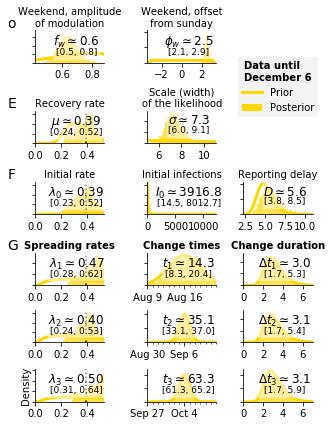

In [14]:
create_figure_distributions(models[0], traces[0],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'Gold',
                              num_changepoints=3, xlim_tbegin=7)

Text(0.05, 0.95, 'Median: 0.39\nCI: [0.24, 0.52]')

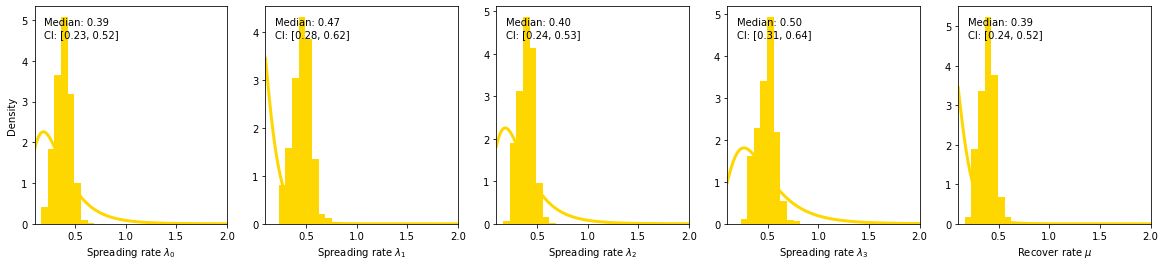

In [15]:
    prio_style = {
    "color": "gold",
    "linewidth": 3,
    "label": "Prior",
}
# styling for posterior distributions
post_style = {
    "density": True,
    "color": "gold",
    "label": "Posterior",
    "zorder": -2,
}

    trace = traces[0]
    posterior = traces[1:]
    figs = []
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    figs.append(fig)

    limit_lambda = (0.1, 2)
    bins_lambda = np.linspace(*limit_lambda, 30)
    
#lambda_0
    ax = axes[0]
    ax.hist(trace.lambda_0, bins=bins_lambda, **post_style)
    x = np.linspace(*limit_lambda, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x + 1 / 8, scale=0.4, s=0.5), **prio_style)
    ax.set_xlim(*limit_lambda)
    ax.set_ylabel("Density")
    ax.set_xlabel("Spreading rate $\lambda_0$")
    ax.text(
        0.05,
        0.95,
        print_median_CI(trace.lambda_0, prec=2),
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    
#lambda_1
    ax = axes[1]
    ax.hist(trace.lambda_1, bins=bins_lambda, **post_style)
    x = np.linspace(*limit_lambda, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x + 1 / 8, scale=0.2, s=0.5), **prio_style)
    ax.set_xlim(*limit_lambda)
    
    ax.set_xlabel("Spreading rate $\lambda_1$")
    ax.text(
        0.05,
        0.95,
        print_median_CI(trace.lambda_1, prec=2),
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    
#lambda_2
    ax = axes[2]
    ax.hist(trace.lambda_2, bins=bins_lambda, **post_style)
    x = np.linspace(*limit_lambda, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x + 1 / 8, scale=0.4, s=0.5), **prio_style)
    ax.set_xlim(*limit_lambda)
    
    ax.set_xlabel("Spreading rate $\lambda_2$")
    ax.text(
        0.05,
        0.95,
        print_median_CI(trace.lambda_2, prec=2),
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    
#lambda_3
    ax = axes[3]
    ax.hist(trace.lambda_3, bins=bins_lambda, **post_style)
    x = np.linspace(*limit_lambda, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x + 1 / 8, scale=0.5, s=0.5), **prio_style)
    ax.set_xlim(*limit_lambda)
    
    ax.set_xlabel("Spreading rate $\lambda_3$")
    ax.text(
        0.05,
        0.95,
        print_median_CI(trace.lambda_3, prec=2),
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
#mu
    ax = axes[4]
    ax.hist(trace.mu, bins=bins_lambda, **post_style)
    x = np.linspace(*limit_lambda, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x + 1 / 8, scale=0.2, s=0.5), **prio_style)
    ax.set_xlim(*limit_lambda)
   
    ax.set_xlabel("Recover rate $\mu$")
    ax.text(
        0.05,
        0.95,
        print_median_CI(trace.mu, prec=2),
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )